In [2]:
import geowombat as gw

In [3]:
from geowombat.data import rgbn, rgbn_suba, rgbn_subb

In [ ]:
with gw.open(rgbn_suba, band_names=['b', 'g', 'r', 'n']) as ds:
    ds.gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)

In [ ]:
with gw.open(rgbn_subb, band_names=['b', 'g', 'r', 'n']) as ds:
    ds.gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)

In [ ]:
with gw.open([rgbn_suba, rgbn_subb], band_names=['b', 'g', 'r', 'n'], mosaic=True) as ds:
    ds.gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)

In [ ]:
with gw.open([rgbn_suba, rgbn_subb, rgbn_subb], 
             time_names=[1, 1, 2], 
             band_names=['b', 'g', 'r', 'n']) as ds:
    
    ds.sel(time=1).gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)

In [4]:
import os
os.path.join(os.path.dirname(rgbn_suba), '*sub*.tif')

'/home/jcgr/.local/lib/python3.6/site-packages/geowombat/data/*sub*.tif'

In [5]:
os.listdir(os.path.dirname(rgbn_suba))

['rgbn.tif', 'rgbn_suba.tif', 'rgbn_subb.tif', '__pycache__', '__init__.py']

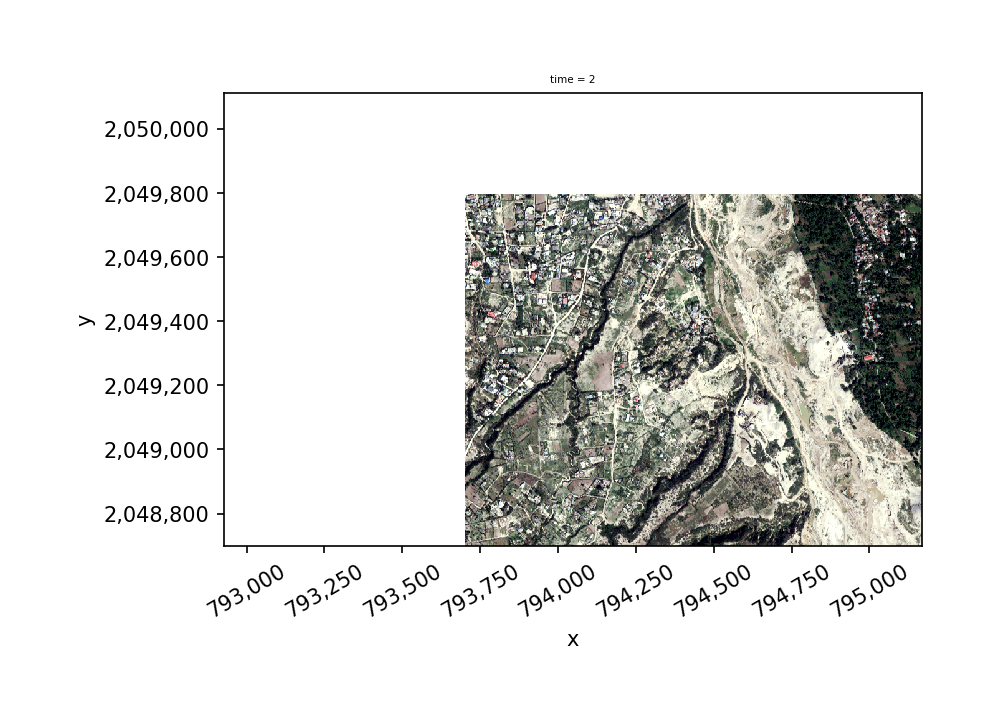

In [7]:
with gw.open(os.path.join(os.path.dirname(rgbn_suba), '*sub*.tif'), 
             band_names=['b', 'g', 'r', 'n']) as ds:

    ds.sel(time=2).gw.imshow(band_names=['b', 'g', 'r'], flip=True, mask=True, nodata=0, robust=True)